[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO Object Detection on a Custom Dataset

---


## Environment setup

In [29]:
import os
from dotenv import load_dotenv

load_dotenv()  # charge .env dans os.environ
api_key = os.getenv("ROBOFLOW_API_KEY")

### Check GPU availability

In [30]:
!nvidia-smi

Sun Jun 29 14:17:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 3GB    On  |   00000000:01:00.0  On |                  N/A |
| 31%   70C    P2             30W /  120W |    2236MiB /   3072MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [31]:
import os
HOME = os.getcwd()
print(HOME)

/home/jovyan/notebooks


### Install dependencies

In [32]:
!pip install roboflow supervision opencv-python ultralytics

Defaulting to user installation because normal site-packages is not writeable


### Download example data


In [5]:
!wget https://images.ctfassets.net/ww1ie0z745y7/2kGaAiLQhWyw0XrRmTf0bB/73112c0436b8b25fa03dec90c23e0a2a/Fish-swimming-together.jpg

--2025-06-29 08:43:46--  https://images.ctfassets.net/ww1ie0z745y7/2kGaAiLQhWyw0XrRmTf0bB/73112c0436b8b25fa03dec90c23e0a2a/Fish-swimming-together.jpg
Resolving images.ctfassets.net (images.ctfassets.net)... 18.244.28.26, 18.244.28.44, 18.244.28.109, ...
Connecting to images.ctfassets.net (images.ctfassets.net)|18.244.28.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 376332 (368K) [image/jpeg]
Saving to: ‘Fish-swimming-together.jpg.7’

Fish-swimming-toget 100%[===================>] 367.51K  --.-KB/s    in 0.08s   

2025-06-29 08:43:46 (4.75 MB/s) - ‘Fish-swimming-together.jpg.7’ saved [376332/376332]



## Run inference


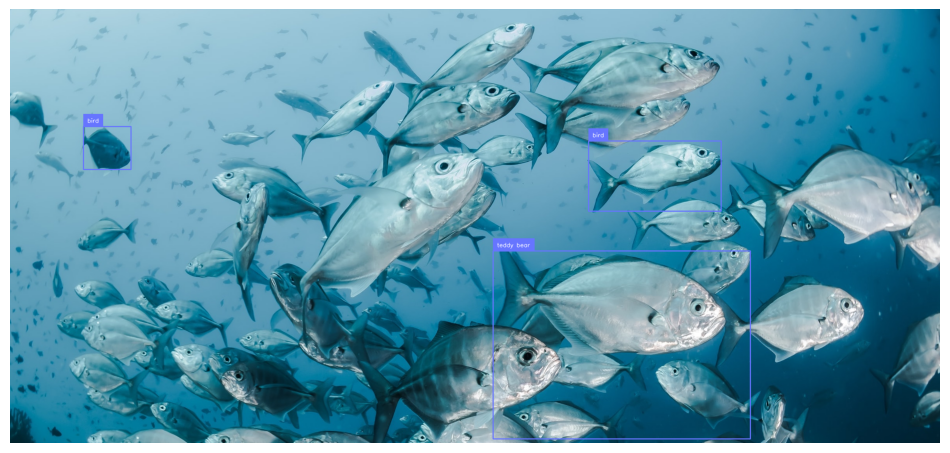

In [33]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/Fish-swimming-together.jpg"
image = cv2.imread(image_path)

model = YOLO('yolov8s.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
!pip install roboflow

import getpass
from roboflow import Roboflow

api_key = getpass.getpass("Entre ta clé API Roboflow (masquée) : ")

rf = Roboflow(api_key=api_key)
project = rf.workspace("detection-b2dbd").project("combined-fish-id")
version = project.version(4)
dataset = version.download("yolov8")

Defaulting to user installation because normal site-packages is not writeable


Entre ta clé API Roboflow (masquée) :  ········


loading Roboflow workspace...
loading Roboflow project...


In [9]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

## Suppression des images sans annotations

In [10]:
import os
from pathlib import Path

# 📍 Modifie ce chemin selon ta structure
DATASET_PATH = Path("/home/jovyan/notebooks/Combined-Fish-ID-4")
IMAGE_DIRS = [DATASET_PATH / "train/images", DATASET_PATH / "valid/images"]
LABEL_DIRS = [DATASET_PATH / "train/labels", DATASET_PATH / "valid/labels"]

# 🔁 Parcourt tous les fichiers .txt des labels
for lbl_dir, img_dir in zip(LABEL_DIRS, IMAGE_DIRS):
    for label_file in lbl_dir.glob("*.txt"):
        # Vérifie si le fichier est vide ou sans vraies annotations
        with open(label_file, "r") as f:
            lines = [line.strip() for line in f if line.strip()]
        
        if len(lines) == 0:
            base_name = label_file.stem
            print(f"🗑️ Suppression : {base_name}")

            # Supprimer le fichier label
            label_file.unlink()

            # Supprimer le fichier image associé (jpg ou png)
            img_path_jpg = img_dir / f"{base_name}.jpg"
            img_path_png = img_dir / f"{base_name}.png"
            img_path_jpeg = img_dir / f"{base_name}.jpeg"

            for img_path in [img_path_jpg, img_path_png, img_path_jpeg]:
                if img_path.exists():
                    img_path.unlink()


## Réquilibrage du dataset

In [11]:
import os
import shutil
from collections import defaultdict
from pathlib import Path
import random

# Dossiers
BASE = Path("/home/jovyan/notebooks/Combined-Fish-ID-4")
TRAIN_IMG = BASE / "train/images"
TRAIN_LBL = BASE / "train/labels"
VALID_IMG = BASE / "valid/images"
VALID_LBL = BASE / "valid/labels"

# Combien d’images de validation on veut par classe ?
TARGET_VALID_RATIO = 0.2  # 20% des données de chaque classe dans valid

# Analyse du dataset
def count_instances(label_dir):
    class_counts = defaultdict(list)
    for label_path in label_dir.glob("*.txt"):
        with open(label_path, "r") as f:
            classes_in_file = set()
            for line in f:
                if line.strip():
                    cls = line.strip().split()[0]
                    classes_in_file.add(cls)
            for cls in classes_in_file:
                class_counts[cls].append(label_path.stem)
    return class_counts

train_counts = count_instances(TRAIN_LBL)
valid_counts = count_instances(VALID_LBL)

print("📊 Répartition actuelle :")
for cls in sorted(train_counts.keys()):
    t = len(train_counts[cls])
    v = len(valid_counts.get(cls, []))
    print(f"Classe {cls}: train={t}, valid={v}")

# Déplacement des fichiers pour équilibrer
for cls, train_files in train_counts.items():
    total = len(train_files) + len(valid_counts.get(cls, []))
    target_valid = int(total * TARGET_VALID_RATIO)
    current_valid = len(valid_counts.get(cls, []))
    to_move = target_valid - current_valid

    if to_move > 0:
        print(f"🔁 Déplacement de {to_move} fichiers de la classe {cls} vers valid/")
        random.shuffle(train_files)
        moved = 0
        for stem in train_files:
            if moved >= to_move:
                break

            src_lbl = TRAIN_LBL / f"{stem}.txt"
            src_img_jpg = TRAIN_IMG / f"{stem}.jpg"
            src_img_png = TRAIN_IMG / f"{stem}.png"

            dst_lbl = VALID_LBL / f"{stem}.txt"
            dst_img_jpg = VALID_IMG / f"{stem}.jpg"
            dst_img_png = VALID_IMG / f"{stem}.png"

            if src_lbl.exists():
                shutil.move(src_lbl, dst_lbl)

            if src_img_jpg.exists():
                shutil.move(src_img_jpg, dst_img_jpg)
            elif src_img_png.exists():
                shutil.move(src_img_png, dst_img_png)

            moved += 1

print("✅ Dataset rééquilibré entre `train` et `valid`.")


📊 Répartition actuelle :
Classe 0: train=1272, valid=318
✅ Dataset rééquilibré entre `train` et `valid`.


In [11]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [35]:
!cat ./fish_dataset/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['fish']


## Fine-tune YOLO model


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

results = model.train(data='./fish_dataset/data.yaml',  project='/home/jovyan/yolo-training', epochs=50, batch=8, patience=10, save_period=5, save=True, workers=2)

New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./fish_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train22, nbs=64, nms=False, opset=Non

train: Scanning /home/jovyan/notebooks/fish_dataset/train/labels.cache... 13579 images, 49 backgrounds, 0 corrupt: 100% 13579/13579 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 536, len(boxes) = 45017. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 48.8±7.2 MB/s, size: 40.1 KB)


val: Scanning /home/jovyan/notebooks/fish_dataset/valid/labels.cache... 1456 images, 4 backgrounds, 0 corrupt: 100% 1456/1456 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 84, len(boxes) = 4585. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /home/jovyan/yolo-training/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /home/jovyan/yolo-training/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.26G      1.494       2.06      1.508         35        640:  70% 1182/1698 [06:57<05:56,  1.45it/s]

## Evaluate fine-tuned YOLOv12 model

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /home/jovyan/yolo-training/train18

F1_curve.png			 labels_correlogram.jpg  train_batch28622.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch2.jpg	 val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch28620.jpg	 val_batch2_pred.jpg
labels.jpg			 train_batch28621.jpg	 weights


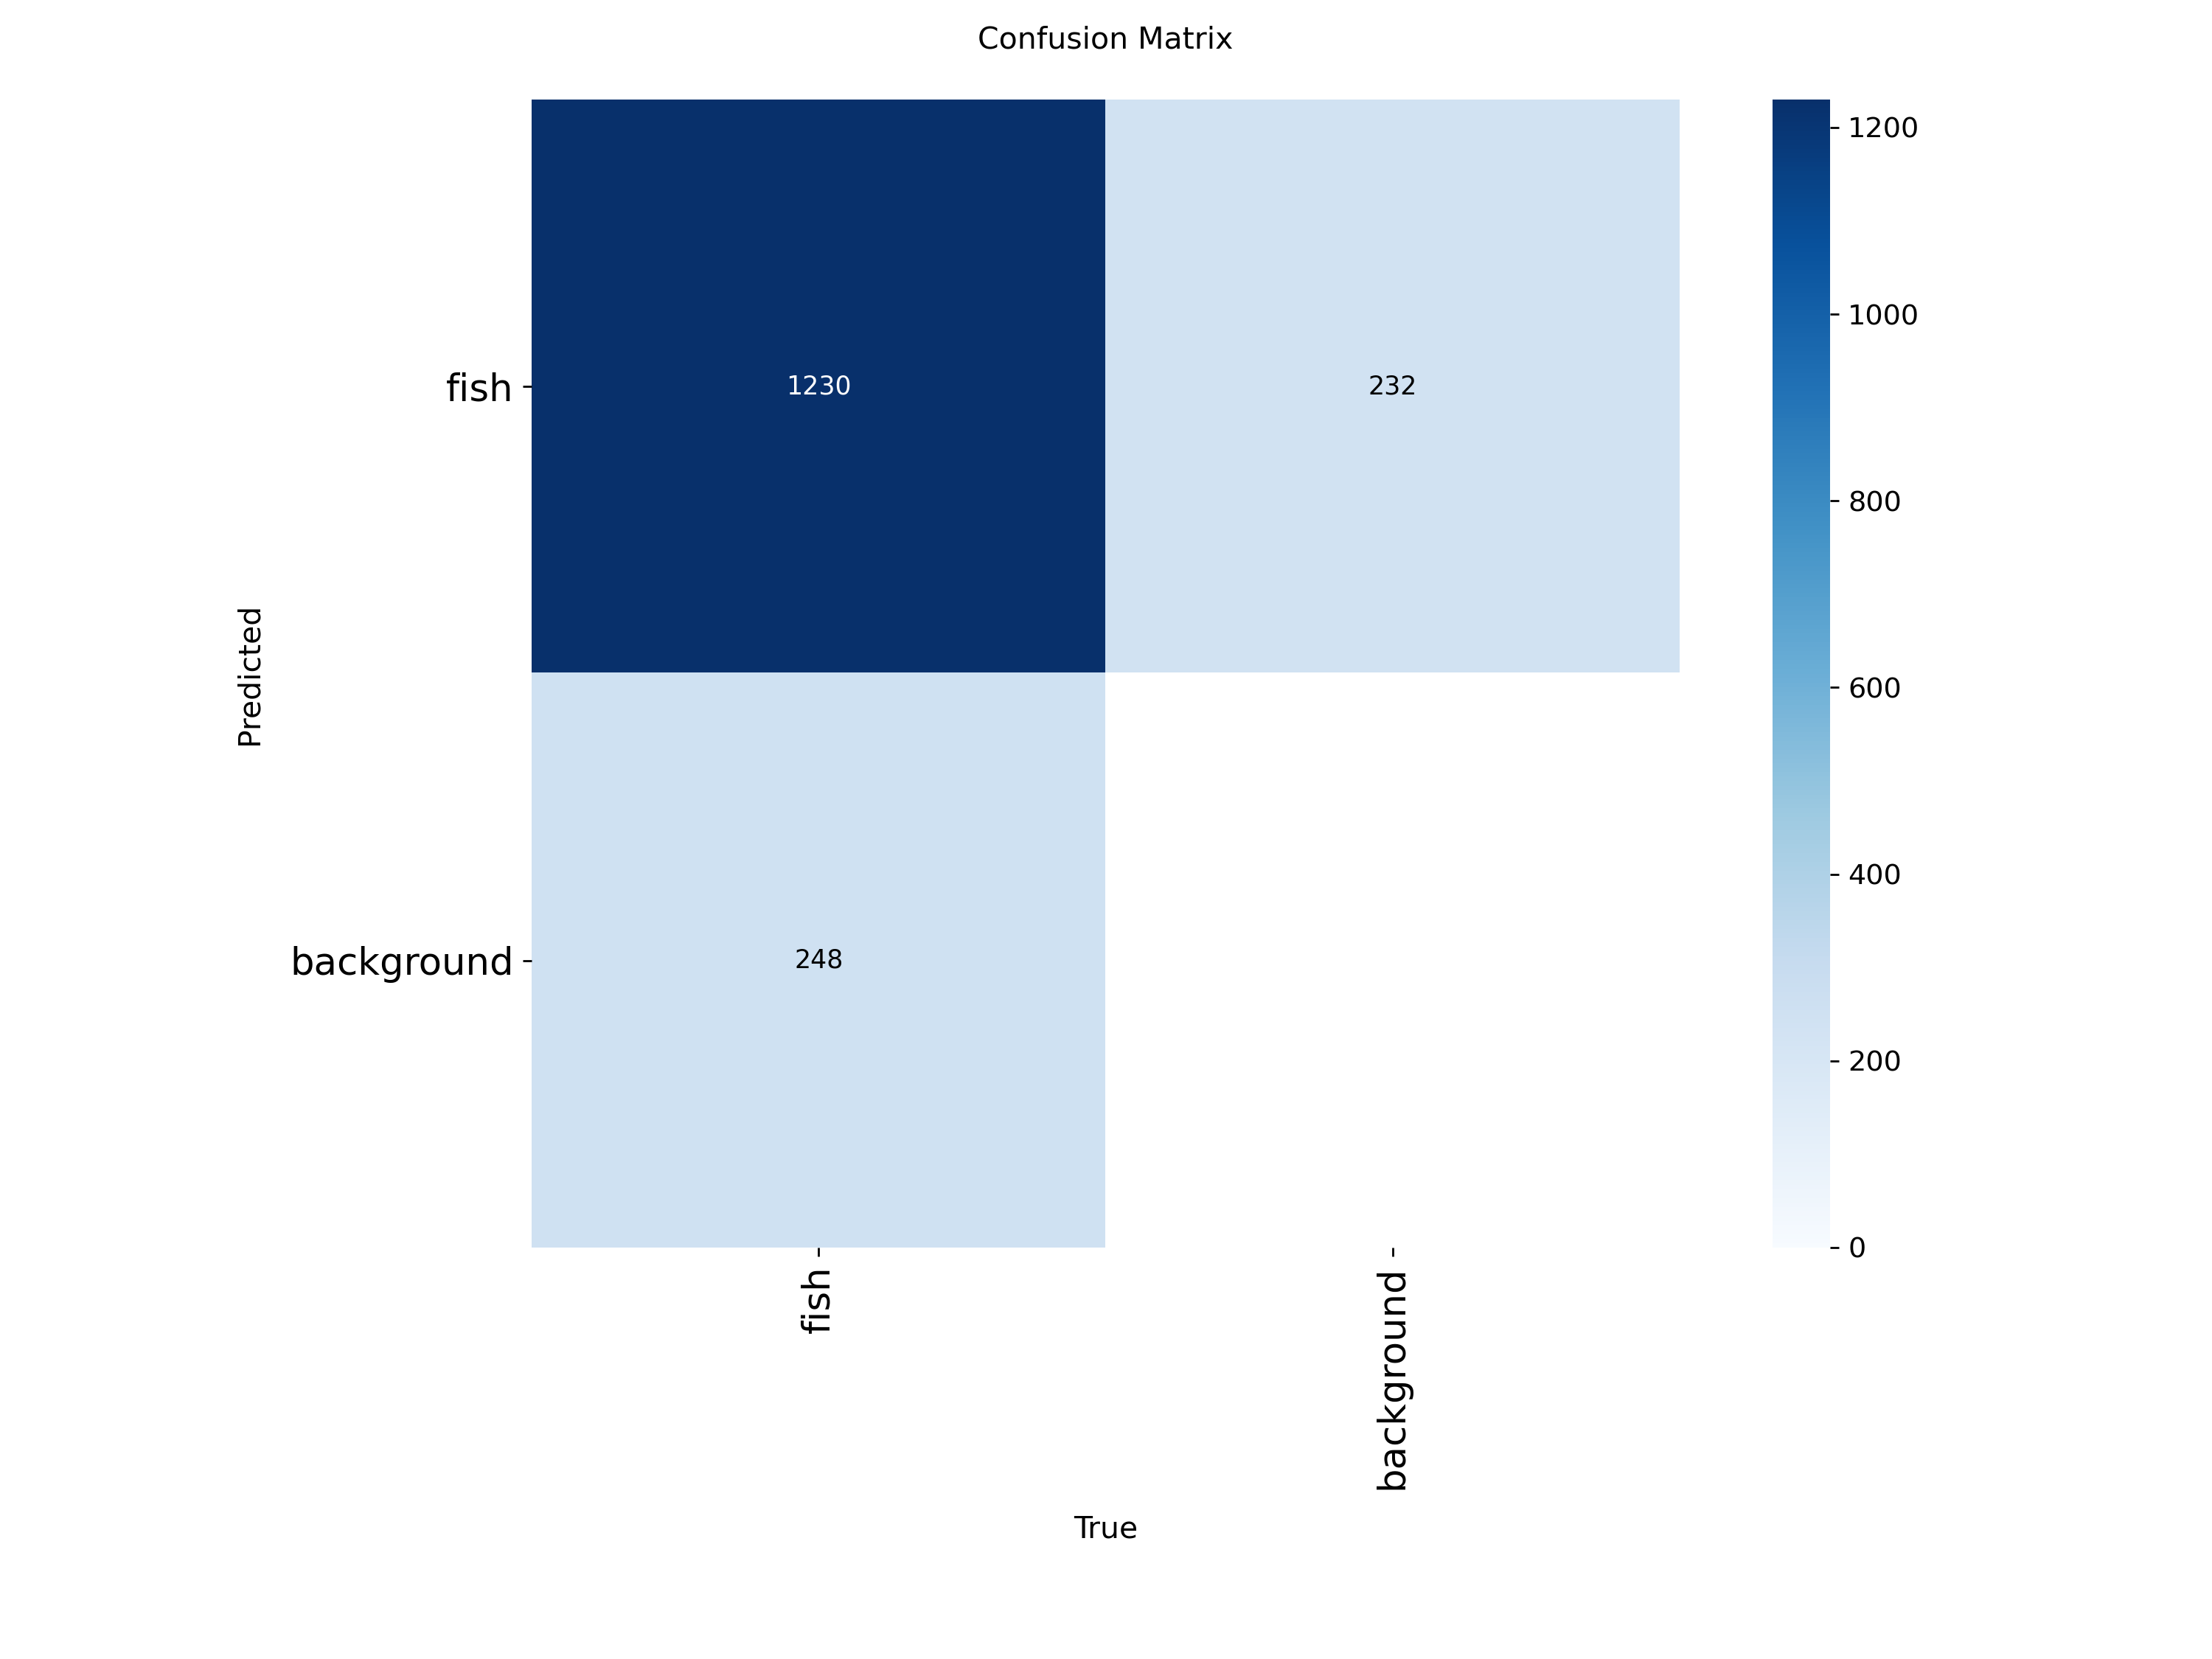

In [16]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train18/confusion_matrix.png', width=1000)

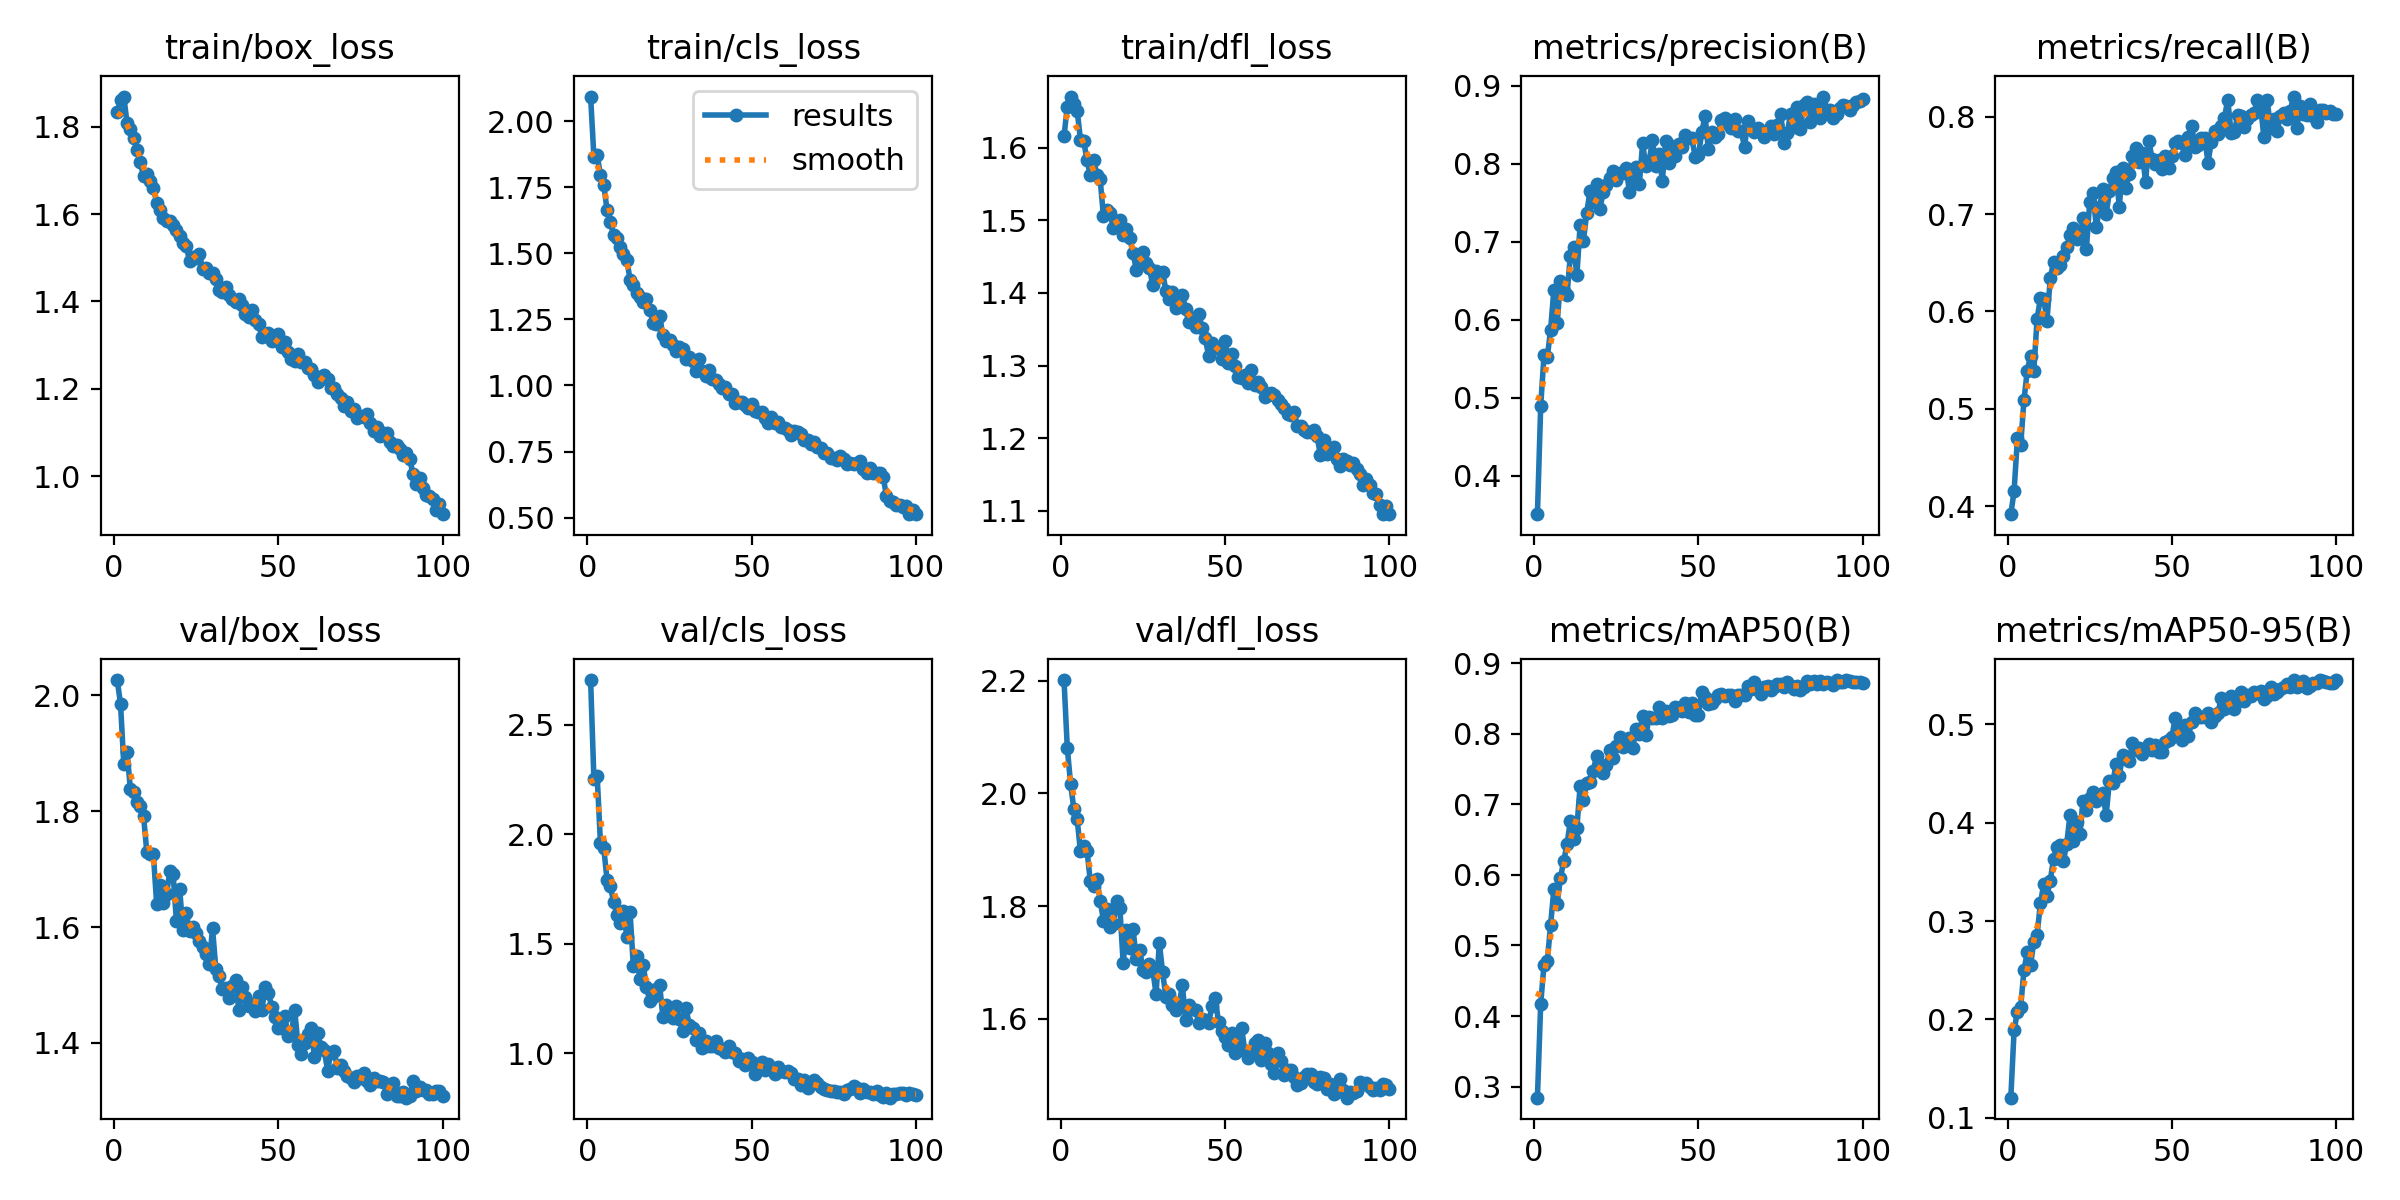

In [17]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train18/results.png', width=1000)

In [18]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['fish']

In [19]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/home/jovyan/yolo-training/train18/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [20]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.4690769582413498
mAP 50 0.758437514366771
mAP 75 0.5259701557843932


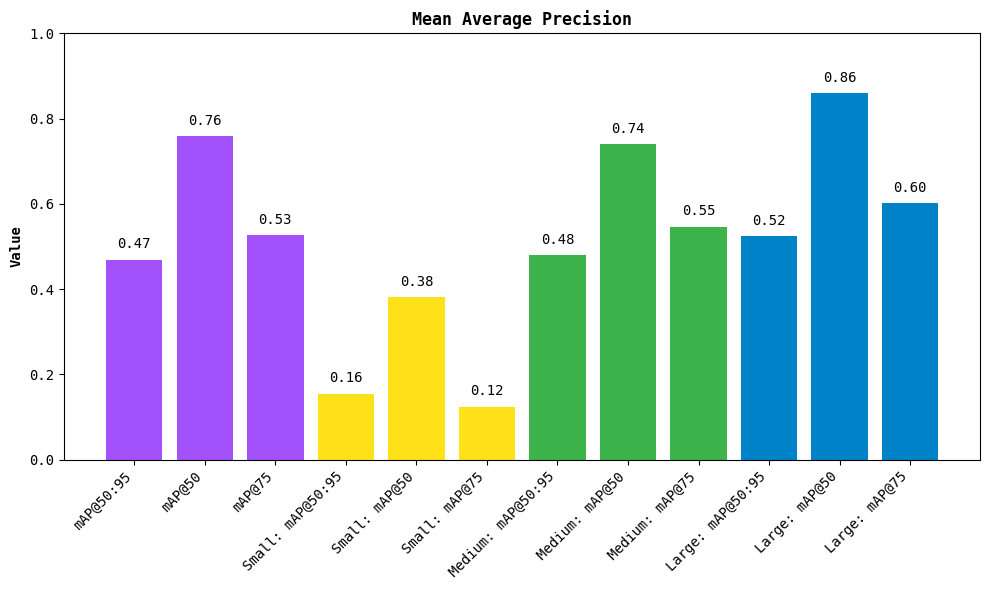

In [21]:
map.plot()

✅ mAP50 ≈ 0.76 → c’est solide (76 % de précision à IoU 0.5)

✅ mAP75 ≈ 0.53 → pas mal du tout, ça montre que la localisation est meilleure qu’avant

✅ mAP50:95 ≈ 0.47 → légèrement mieux que précédemment (~+2 %)

📊 Interprétation
YOLOv8s a clairement mieux appris que YOLOv8n (tu gagnes ~2 % de mAP50:95, et la précision pure mAP50 est meilleure)

on est probablement encore limité par la difficulté des images sous-marines (faible contraste, poissons qui se confondent, etc.)

0.47 de mAP50:95 reste exploitable pour du prototype et du suivi d’espèces



## Run inference with fine-tuned YOLO model

In [22]:
import supervision as sv

model = YOLO(f'/home/jovyan/yolo-training/train18/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

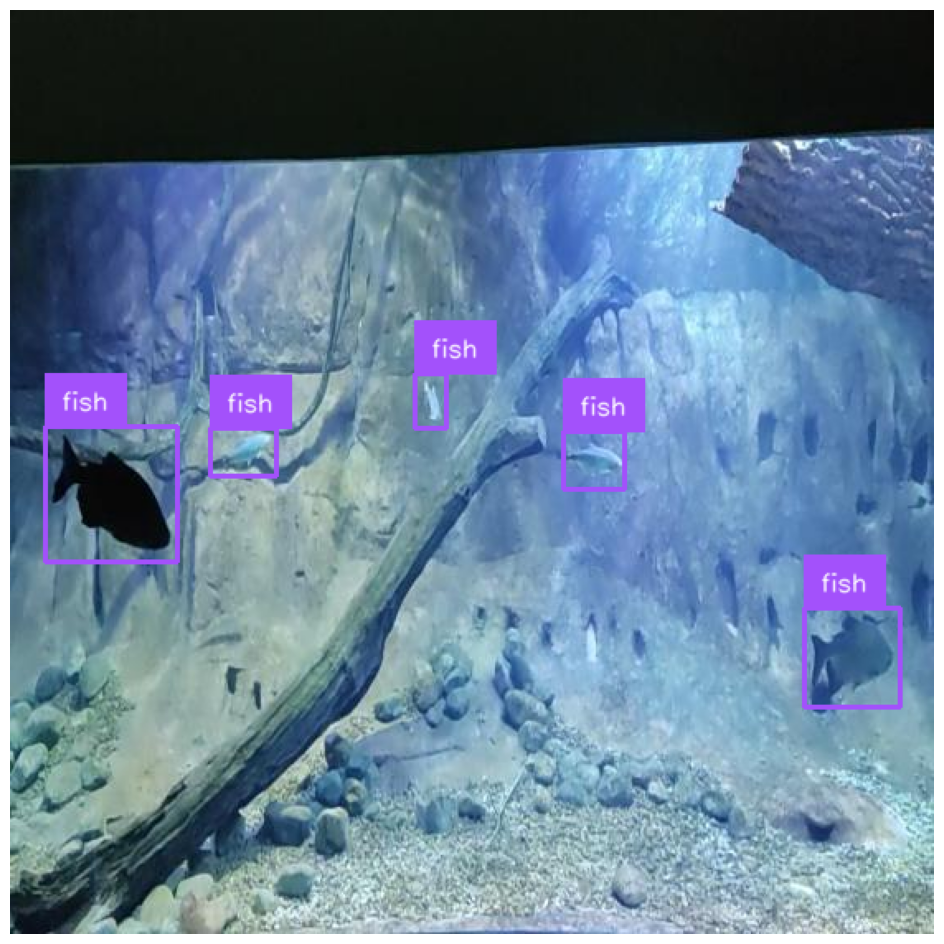

In [27]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-29 12:20:56--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-29 12:20:56--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-29 12:20:56--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (

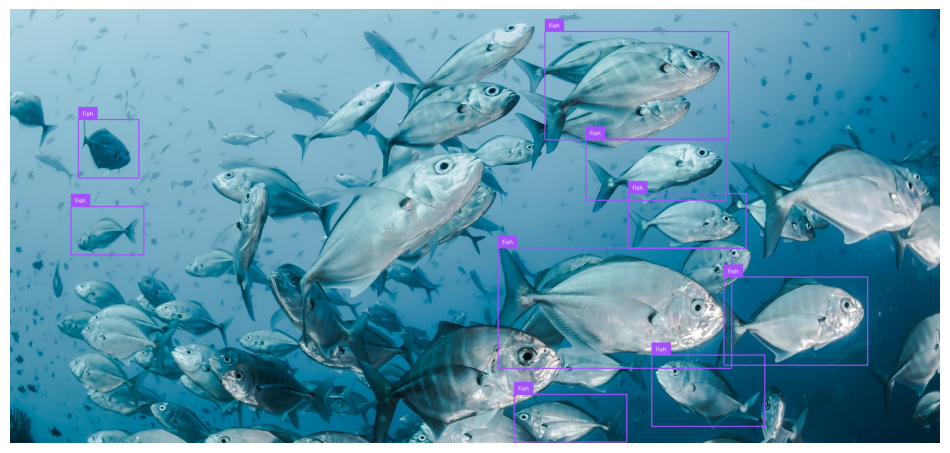

In [28]:
model = YOLO(f'/home/jovyan/yolo-training/train18/weights/best.pt')

!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

image_path = f"{HOME}/Fish-swimming-together.jpg"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)